# Histopathologic Cancer Detection 
#### Aim: Create algorithm to identify metastatic cancer from small image patches taken from the larger digital pathology scans. 
#### These images are taken from the modified version of PathCamelon (PCam) benchmark dataset (duplicate entries have been removed, NB: duplicate entries existed owing to probabilistic sampling)

 Data description: Dataset contains large number of small pathology images to classify. Files are named with an image "id"
 The train_labels.csv file provides the ground truh for the images in the train folder. 
 We are predicting labels for the images in the test folder.
 A positive label indicates that the center 32x32px region of a patch contains atleast 1 pixel of tumor tissue. 
 Tumor tissue in the outer region of the patch does not influence the label. The outer region is provided to enable fully convolutional models which do not use padding to ensure consistend behaviour when applied to the whole slide. 
 
 
 Run the following cell to run all the packages and dependencies 

## Packages and other dependencies

In [8]:
### load required packages ###
import os # miscellaneous operating system interfaces
import numpy as np # linear algebra
import pandas as pd # dataprocessing
from glob import glob 
import zipfile # read ZIP file
import json 
import shutil # copy/remove on files and collection of files 
# (high-level file and directory handling)

import h5py # needed to checkpoint: specifically to output network weights in HDF5 format.
# look at the data files
from subprocess import check_output
from imutils import paths #A series of convenience functions to 
# make basic image processing functions such as translation, 
# rotation, resizing, skeletonization, displaying Matplotlib 
# images, sorting contours, detecting edges, and much more easier
# with OpenCV and both Python 2.7 and Python 3.
import random # to generate psuedo random numbers
import PIL

# import function to split arrays into random train and test subsets 
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score

from keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array;
from keras.applications.resnet50 import ResNet50;
from keras.models import Sequential;
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation;
from keras.layers import Conv2D, MaxPool2D;
from keras import optimizers;
from keras.callbacks import EarlyStopping, ReduceLROnPlateau;
from keras.callbacks import TensorBoard;
# Checkpoint the weights when validation accuracy improves
from keras.callbacks import ModelCheckpoint;

%reload_ext autoreload
%autoreload 2
import matplotlib.pyplot as pyplot
%matplotlib inline

Using TensorFlow backend.
/home/bithika/local/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/bithika/local/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/bithika/local/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/bithika/local/anaconda3/lib/p

In [9]:
os.system("mkdir -p {} {}".format(base_dir, checkpoint_dir))

NameError: name 'base_dir' is not defined

In [2]:
# Set paths that you will use in this notebook 
base_dir = os.path.join('/home/bithika/ml/Kaggle/pcam/')
checkpoint_dir = os.path.join(base_dir, 'checkpoints') 
!mkdir -p "{base_dir}"
!mkdir -p "{checkpoint_dir}"

## Define Constants

In [3]:
# the amount of validation data will be a percentage of the
# *training* data
VAL_SPLIT = .125

# define the total number of epochs to train for along with the
# initial learning rate and batch size
NUM_EPOCHS = 5 # training iterations
INIT_LR = 1e-3 # initial learning rate
BATCH_SIZE = 32 # batch size of 32 is good for CPUs, take 64 for GPUs

(HEIGHT, WIDTH) = (224, 224)# rescale images (higher performance; crop images)
(DEF_HEIGHT, DEF_WIDTH) = (96,96) # used for test data

DROPOUT_RATE = 0.5

## Explore training data

In [4]:
# training, validation, and testing directories
VALTRAIN_PATH = os.path.sep.join([base_dir, "VALTRAIN"])
TEST_PATH = os.path.sep.join([base_dir, "TEST"])

In [5]:
# grab the paths to all the input images in the TRAIN directory
# and shuffle them 
valtrainPaths = list(paths.list_images(VALTRAIN_PATH))
random.seed(42)
random.shuffle(valtrainPaths)

 we need to make a dataframe contanint the every training and validation example image's path, id and labels


In [6]:
# SAVE train_labels.csv as a dataframe
labels = pd.read_csv(os.path.join(base_dir,'train_labels.csv'))

In [7]:
# now we want to add filepath's to a dataframe which also contains id and label
# we use glob. Globbing is a technical term for matching files by name or type of file. 
# here we use it to match by file type. 
# we need to go into subfolders "oldtrain" inside the VAL_TRAIN_PATH - this should be created before we split data

# join the folder 
val_train_tif = os.path.join(VALTRAIN_PATH,"oldtrain")


In [8]:
# using globbing to match all files with .tif file type and save in a dataframe
path_labels = pd.DataFrame({'path':glob(os.path.join(val_train_tif,'*.tif'))})

In [9]:
path_labels.head() # glance at the data

,path
0,/home/bithika/ml/Kaggle/pcam//VALTRAIN/oldtrai...
1,/home/bithika/ml/Kaggle/pcam//VALTRAIN/oldtrai...
2,/home/bithika/ml/Kaggle/pcam//VALTRAIN/oldtrai...
3,/home/bithika/ml/Kaggle/pcam//VALTRAIN/oldtrai...
4,/home/bithika/ml/Kaggle/pcam//VALTRAIN/oldtrai...


In [10]:
# we add another column labeled 'id'  to the path_labels dataframe
# it's value is just the file name of the tif file saved in a specific filepath 
path_labels['id'] = path_labels.path.map(lambda x : ((x.split('n/')[1].split('.')[0])))

# merge dataframes on label = 'id'
path_labels = path_labels.merge(labels, on='id')

Choose 6 random positive and negative examples, find their respective path and then display them in subplot

In [11]:
positive_indices = list(np.where(path_labels["label"] == True)[0])
negative_indices = list(np.where(path_labels["label"] == False)[0])

# take 3 random positive indices and negative indices
random_positive_indices = random.sample(positive_indices,3)
random_negative_indices = random.sample(negative_indices,3)

In [12]:
def img_load_array(path):
    """
    Convert loaded image to an numpy array
    
    Prereq: numpy, from keras_preprocessing.image import img_to_array, load_img
    
    Argument: path (dtype: string)
    
    Return:Image as an numpy array 
    """
    ## Read in the current image
    image_keras = load_img(path)
    # Convert image to numpy array
    image_array = img_to_array(image_keras)
    
    return image_array
    

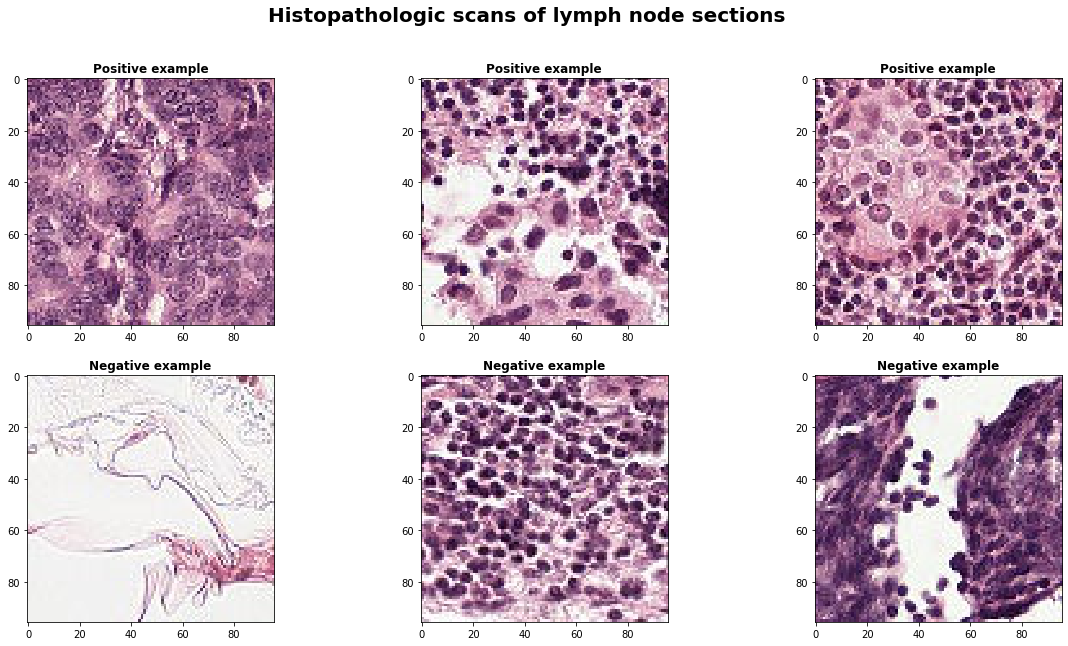

In [13]:
fig, ax = pyplot.subplots(2,3, figsize=(20,10)) # 2 rows and 3 columns

# Add a centered title to the figure.
fig.suptitle('Histopathologic scans of lymph node sections',fontsize=20, fontweight='bold')

for i in range(0,3):
    # Display image in first row and i'th column axes location - 1/255 ensures that RGB values are in range [0,1] for float values 
    ax[0,i].imshow(img_load_array(path_labels.iloc[random_positive_indices[i],0])/255)
    # Set a  centered title for the image diplayed at axes defined above 
    ax[0,i].set_title("Positive example", fontweight = 'bold')
    
    # Display image in first row and i'th column axes location - 1/255 ensures that RGB values are in range [0,1] for float values 
    ax[1,i].imshow(img_load_array(path_labels.iloc[random_negative_indices[i],0])/255)
    # Set a  centered title for the image diplayed at axes defined above 
    ax[1,i].set_title("Negative example", fontweight = 'bold')


## Split train data into training and validation datasets 

Classic way with ```train_test_split```

In [1]:
TestPaths = list(paths.list_images(TEST_PATH)) # list files inside 
ValTrainPaths = list(paths.list_images(VALTRAIN_PATH)) # list files inside 
print("There are " + str(len(ValTrainPaths)) + " training examples.")
print("There are " + str(len(TestPaths)) + " test examples.")

NameError: name 'paths' is not defined

Split 20% of training dataset into validation dataset


In [15]:
path_labels['label']= path_labels['label'].astype(str)  # cast label values as str dtype
TrainPaths, ValidPaths = train_test_split(path_labels, test_size = 0.2,random_state = 220, stratify = path_labels['label']) # split pandas
# dataframe 20% of valtrain data is saved as validation data using the random seed defined 
# above and stratified by 'labels' in panda dataframe


In [ ]:
TrainP

## Data augmentation using data from train_test_split function

In [16]:
# initialize the training training data augmentation object
    # rescale 
TrainAugmentation = ImageDataGenerator(
    # include? preprocessing_function=preprocess_input only if using keras inbuilt resnet
	rescale=1 / 255.0, # normalisation: scaling data to the range
    # of 0-1
    rotation_range= 90, # degrees
    # Horizontal and Vertical Shift Augmentation
    width_shift_range=0.1, # fraction of total width
    height_shift_range=0.1, # fraction of total height
    zoom_range=0.2, # i.e zoom range is [0.95,1.05] 
    # not sure about keeping 0.05
    shear_range=0.05, 
	horizontal_flip=True,
    vertical_flip= True
    )

# fill_mode="nearest"

# initialize the validation (and testing) data augmentation object
Val_Test_Augmentation = ImageDataGenerator(rescale=1 / 255.0)

In [17]:
TrainGenerator = TrainAugmentation.flow_from_dataframe(dataframe = TrainPaths, 
                                                       directory = None, 
                                                       x_col = 'path',
                                                       y_col = 'label',
                                                       color_mode = "rgb",
                                                       target_size = (HEIGHT, WIDTH),
                                                       class_mode = "binary",
                                                       batch_size = BATCH_SIZE, 
                                                       seed = 10986,
                                                       shuffle = True)
# could use interpolation = "bicubic" if I intend to crop the images

Found 176020 validated image filenames belonging to 2 classes.


In [18]:
ValidGenerator = Val_Test_Augmentation.flow_from_dataframe(dataframe = ValidPaths,
                                                           directory = None,
                                                           x_col = 'path',
                                                           y_col = 'label',
                                                           target_size = (HEIGHT, WIDTH),
                                                           color_mode = "rgb",
                                                           class_mode = "binary",
                                                           batch_size = BATCH_SIZE, 
                                                           shuffle = False) # shuffling is 
                                                           

Found 44005 validated image filenames belonging to 2 classes.


## Creating the model 

CNN has two parts:
1. **Convolutional base:** which is composed by a stack of convolutional and pooling layers. The main goal of the convolutional base is to generate features from the image. For an intuitive explanation of convolutional and pooling layers, please refer to Chollet (2017)
2. **Classifier:** which is usually composed by fully connected layers. The main goal of the classifier is to classify the image based on the detected features. A fully connected layer is a layer whose neurons have full connections to all activation in the previous laye

In [19]:
# load pretrained ResNet-50 
# Convolutional base, which performs feature extraction.
ConvolutionalBase = ResNet50(include_top=False,
                             weights='imagenet',
                             input_shape=(HEIGHT, WIDTH,3));

/home/bithika/local/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [20]:
# Classifier: Use fully connected layers. In this classifier we add a stack of 
# fully-connected layers which is fed by features extracted from the convolutional 
# base

model = Sequential() #crease a sqequntial model
# add layers 
model.add(ConvolutionalBase)
model.add(Flatten())# A tensor, reshaped into 1-D
model.add(Dense(256, use_bias=False)) # regular densely-connected NN layer with 
# dimensions 256
model.add(BatchNormalization())
model.add(Activation("relu")) # Applies an activation function to an output, 
# retains shape
model.add(Dropout(DROPOUT_RATE)) # this core layer randomly sets a fraction of 
# input units to
# 0 at each update during training time, which helps prevent overfitting
model.add(Dense(1,activation= 'sigmoid'))
model.summary()


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               25690112  
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
activation_50 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
___________________________

Now we need to train the last few layers instead of just the last one. This is because of the size-similarity matrix, since our task is to identify cancer cells Imagenet can't be considered a similar dataset.  In principle as we have a large dataset we can train the model from scratch but it can be useful to initialize the model from a pretrained model, using its architecture and weights. We use ResNet50 ```keras``` implementation for this. 

We start by retraining, 143th layer of ResNet50 i.e 'res5a_branch2a'

In [21]:
set_trainable=False
for layer in ConvolutionalBase.layers:
    if layer.name == 'res5a_branch2a':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [22]:
#compile the model
model.compile(optimizers.Adam(INIT_LR), loss = "binary_crossentropy",
              metrics = ["accuracy"])


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Train model

In [23]:
Train_step_size = TrainGenerator.n // TrainGenerator.batch_size
Valid_step_size = ValidGenerator.n // ValidGenerator.batch_size

In [24]:
# Stop training when a monitored quantity has stopped improving.
early_stopper = EarlyStopping(monitor='val_loss', patience=3, verbose=2,
                              restore_best_weights=True)
# Reduce learning rate when a metric has stopped improving.
reduce = ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.1)

In [25]:
# checkpoint
# IMP for userdefined callbacks: 
# alternative solution is to pickle the callback instance every time we save a 
# checkpoint, then we can load this pickle when resuming and reconstruct the original
# callback with all its correct values. 
filepath = os.path.join(checkpoint_dir, "saved-model-{epoch:02d}-{val_acc:.3f}.hdf5")
# Setting 'save_weights_only' to False in the Keras callback 'ModelCheckpoint' will 
# save the full model
checkpoint = ModelCheckpoint(filepath, monitor='val_loss',
                             verbose=0, save_best_only=False, 
                             save_weights_only=False, mode='auto', period=1)


In [26]:
callback_list = [early_stopper, reduce, checkpoint]

In [27]:
history = model.fit_generator(TrainGenerator,
                              steps_per_epoch=Train_step_size,
                              epochs=NUM_EPOCHS, verbose = 1,
                              callbacks= callback_list,
                              validation_data=ValidGenerator,
                              validation_steps=Valid_step_size,
                              use_multiprocessing = False)

Epoch 1/5
5500/5500 [==============================] - 3761s 684ms/step - loss: 0.2732 - acc: 0.8910 - val_loss: 0.2131 - val_acc: 0.9168
Epoch 2/5
5500/5500 [==============================] - 3782s 688ms/step - loss: 0.2228 - acc: 0.9138 - val_loss: 0.1915 - val_acc: 0.9283
Epoch 3/5
5500/5500 [==============================] - 3782s 688ms/step - loss: 0.1982 - acc: 0.9247 - val_loss: 0.1839 - val_acc: 0.9306
Epoch 4/5
5500/5500 [==============================] - 3784s 688ms/step - loss: 0.1848 - acc: 0.9299 - val_loss: 0.1882 - val_acc: 0.9309

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 5/5
5500/5500 [==============================] - 3790s 689ms/step - loss: 0.1621 - acc: 0.9397 - val_loss: 0.1633 - val_acc: 0.9413


## Post training:
Plot training graphs to ascertain performance via accuracies and losses varied over epochs


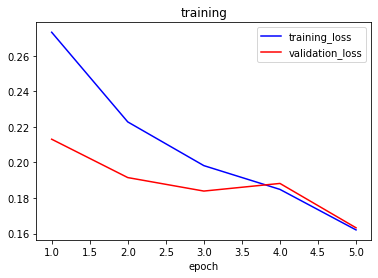

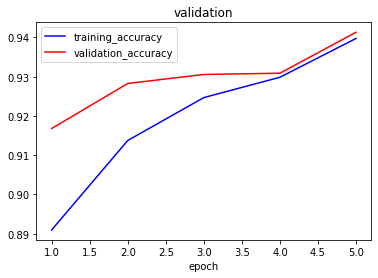

In [31]:
epochs = [i for i in range(1, len(history.history['loss'])+1)]

pyplot.plot(epochs, history.history['loss'], color='blue', label="training_loss")
pyplot.plot(epochs, history.history['val_loss'], color='red', label="validation_loss")
pyplot.legend(loc='best')
pyplot.title('training')
pyplot.xlabel('epoch')
pyplot.savefig("training.png", bbox_inches='tight')
pyplot.show()

pyplot.plot(epochs, history.history['acc'], color='blue', label="training_accuracy")
pyplot.plot(epochs, history.history['val_acc'], color='red',label="validation_accuracy")
pyplot.legend(loc='best')
pyplot.title('validation')
pyplot.xlabel('epoch')
pyplot.savefig("validation.png", bbox_inches='tight')
pyplot.show()

ROC Plot

Found 44005 validated image filenames belonging to 2 classes.


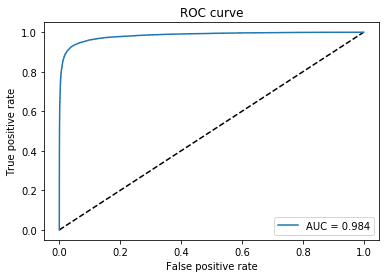

In [33]:
roc_validation_generator = ImageDataGenerator(rescale=1./255).flow_from_dataframe(ValidPaths,
                                                                                  x_col = 'path',
                                                                                  y_col = 'label',
                                                                                  target_size = (HEIGHT, WIDTH),
                                                                                  class_mode = 'binary',
                                                                                  batch_size = BATCH_SIZE,
                                                                                  shuffle = False)

predictions = model.predict_generator(roc_validation_generator, steps=len(roc_validation_generator), verbose=2)
false_positive_rate, true_positive_rate, threshold = roc_curve(roc_validation_generator.classes, predictions)
area_under_curve = auc(false_positive_rate, true_positive_rate)

pyplot.plot([0, 1], [0, 1], 'k--')
pyplot.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
pyplot.xlabel('False positive rate')
pyplot.ylabel('True positive rate')
pyplot.title('ROC curve')
pyplot.legend(loc='best')
pyplot.savefig('ROC_PLOT.png', bbox_inches='tight')
pyplot.show()

## Predictions

In [ ]:
Test_df = pd.DataFrame({'path': glob(os.path.join(TestPaths, '*.tif'))})

In [ ]:
Test_df['id'] = Test_df.path.map(lambda x: (x.split('t/')[1].split('.')[0]))
Test_df.head(3)

In [ ]:
TestAugmentation = ImageDataGenerator(rescale=1./255, #Normalise
                                 vertical_flip = True,
                                 horizontal_flip = True,
                                 rotation_range=90,
                                 zoom_range=0.2, 
                                 width_shift_range=0.1,
                                 height_shift_range=0.1,
                                 shear_range=0.05,
                                 channel_shift_range=0.1)

## Resume from checkpoints

In [ ]:
# initialize callbacks:
checkpoint_callback = ModelCheckpoint( filepath = "saved-model-{epoch:02d}-{val_acc:.3f}.hdf5")
# Stop training when a monitored quantity has stopped improving.
early_stopper = EarlyStopping(monitor='val_loss', patience=3, verbose=2,
                              restore_best_weights=True)
# Reduce learning rate when a metric has stopped improving.
reduce = ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.1)